## Delaunay Triangulation 
### Algorithm Name: Edge Flipping


## What is the Flipping property of Delaunay triangulation

**Important property of a delaunay triangulation**: A circle circumscribing any Delaunay triangle does not contain any other input points in its in
interior.

Proof:

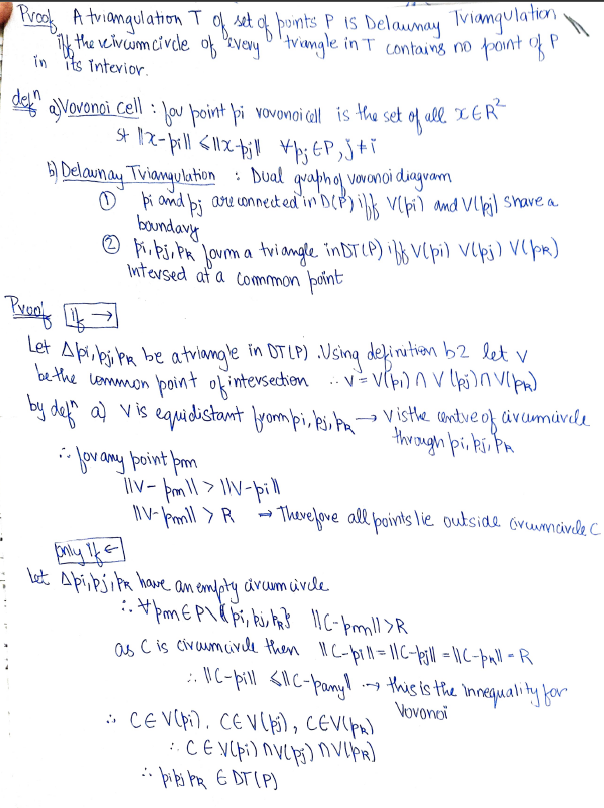

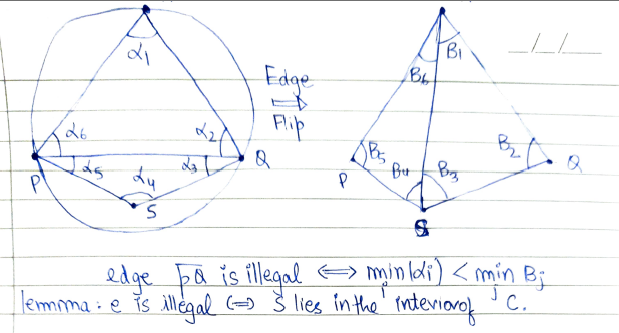

source: https://www.youtube.com/watch?v=7SDSIUSZOB8

From the above property an important feature arises:
Looking at two triangles △ABD, △BCD with the common edge BD, if the sum of the angles α + γ ≤ 180°, the triangles meet the Delaunay condition.

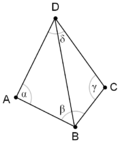

This leads to the important technique called the **flip technique**
If two triangles do not meet the Delaunay condition, switching the common edge BD for the common edge AC produces two triangles that do meet the Delaunay condition:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [2]:
def generate_random_points(n_points=50, x_range=(0, 1), y_range=(0, 1), seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.random.uniform(x_range[0], x_range[1], n_points)
    y = np.random.uniform(y_range[0], y_range[1], n_points)
    
    points = np.column_stack((x, y))
    return points

def generate_gaussian_points(n_points=50, mean=(0.5, 0.5), cov=None, seed=None):
    """2D Gaussian distributed points."""
    if seed is not None:
        np.random.seed(seed)
    if cov is None:
        cov = [[0.02, 0.0], [0.0, 0.02]]  # isotropic default covariance
    points = np.random.multivariate_normal(mean, cov, n_points)
    return np.clip(points, 0, 1)  # keep in [0,1] range


def generate_poisson_disc_points(radius=0.2, x_range=(0, 1), y_range=(0, 1), k=30, seed=None):
    """
    Poisson disk sampling (Blue noise).
    - radius: minimum distance between points.
    - k: number of candidates per active point.
    """
    if seed is not None:
        np.random.seed(seed)

    width, height = x_range[1] - x_range[0], y_range[1] - y_range[0]
    cell_size = radius / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(width / cell_size)), int(np.ceil(height / cell_size))
    grid = -np.ones((grid_h, grid_w), dtype=int)
    points = []
    active_list = []

    def in_bounds(p):
        return x_range[0] <= p[0] <= x_range[1] and y_range[0] <= p[1] <= y_range[1]

    def grid_coords(p):
        return int((p[0] - x_range[0]) / cell_size), int((p[1] - y_range[0]) / cell_size)

    def too_close(p):
        gx, gy = grid_coords(p)
        for i in range(max(gy - 2, 0), min(gy + 3, grid_h)):
            for j in range(max(gx - 2, 0), min(gx + 3, grid_w)):
                idx = grid[i, j]
                if idx != -1:
                    dist = np.linalg.norm(points[idx] - p)
                    if dist < radius:
                        return True
        return False

    # Initial point
    first_point = np.array([
        np.random.uniform(x_range[0], x_range[1]),
        np.random.uniform(y_range[0], y_range[1])
    ])
    points.append(first_point)
    active_list.append(0)
    gx, gy = grid_coords(first_point)
    grid[gy, gx] = 0

    while active_list:
        idx = np.random.choice(active_list)
        base_point = points[idx]
        found = False
        for _ in range(k):
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(radius, 2 * radius)
            new_point = base_point + np.array([r * np.cos(theta), r * np.sin(theta)])
            if in_bounds(new_point) and not too_close(new_point):
                points.append(new_point)
                gx, gy = grid_coords(new_point)
                grid[gy, gx] = len(points) - 1
                active_list.append(len(points) - 1)
                found = True
                break
        if not found:
            active_list.remove(idx)
    return np.array(points)


def generate_clustered_points(n_points=100, n_clusters=3, x_range=(0, 1), y_range=(0, 1), seed=None):
    """Multiple dense clusters with sparse regions between them."""
    if seed is not None:
        np.random.seed(seed)
    cluster_centers = np.random.uniform([x_range[0], y_range[0]], [x_range[1], y_range[1]], (n_clusters, 2))
    points_per_cluster = n_points // n_clusters
    remainder = n_points % n_clusters
    points = []
    for i, center in enumerate(cluster_centers):
        size = points_per_cluster + (1 if i < remainder else 0)
        cov = np.diag(np.random.uniform(0.001, 0.01, 2))
        cluster = np.random.multivariate_normal(center, cov, size)
        points.append(cluster)
    return np.clip(np.vstack(points), 0, 1)

In [3]:
import numpy as np

def triangulate_flipping(points):
    pts = np.asarray(points, dtype=float)
    n = len(pts)
    if n < 3:
        return [], 0

    # ---------------------------------------------------------
    # Basic geometry helpers
    # ---------------------------------------------------------
    def orient(p, q, r):
        """Positive if p->q->r is CCW, negative if CW."""
        return (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])

    def in_circle_raw(a, b, c, d):
        """Signed determinant for in-circle test."""
        ax, ay = a[0] - d[0], a[1] - d[1]
        bx, by = b[0] - d[0], b[1] - d[1]
        cx, cy = c[0] - d[0], c[1] - d[1]
        return (ax*ax + ay*ay) * (bx*cy - cx*by) - \
               (bx*bx + by*by) * (ax*cy - cx*ay) + \
               (cx*cx + cy*cy) * (ax*by - bx*ay)

    def in_circle_idx(i, j, k, l):
        a, b, c, d = pts[i], pts[j], pts[k], pts[l]
        det = in_circle_raw(a, b, c, d)
        if orient(a, b, c) < 0:  # make (a,b,c) effectively CCW
            det = -det
        return det > 0   # points on the circle (det == 0) are treated as legal

    # ---------------------------------------------------------
    # Convex hull (Monotone chain, returns indices in CCW order)
    # ---------------------------------------------------------
    def convex_hull_indices():
        if n < 3:
            return list(range(n))

        order = sorted(range(n), key=lambda i: (pts[i][0], pts[i][1]))

        def cross(i, j, k):
            return orient(pts[i], pts[j], pts[k])

        lower = []
        for i in order:
            while len(lower) >= 2 and cross(lower[-2], lower[-1], i) <= 0:
                lower.pop()
            lower.append(i)

        upper = []
        for i in reversed(order):
            while len(upper) >= 2 and cross(upper[-2], upper[-1], i) <= 0:
                upper.pop()
            upper.append(i)

        hull = lower[:-1] + upper[:-1]
        # If all points are collinear, hull will have < 3 points
        return hull

    hull = convex_hull_indices()
    if len(hull) < 3:
        # Degenerate: all points collinear
        return [], 0

    # ---------------------------------------------------------
    # Half-edge structure: (u, v) -> w  where triangle is (u, v, w) CCW
    # ---------------------------------------------------------
    half_edge = {}

    def add_triangle(u, v, w):
        # Enforce CCW orientation
        if orient(pts[u], pts[v], pts[w]) < 0:
            v, w = w, v
        half_edge[(u, v)] = w
        half_edge[(v, w)] = u
        half_edge[(w, u)] = v

    def remove_triangle(u, v, w):
        del half_edge[(u, v)]
        del half_edge[(v, w)]
        del half_edge[(w, u)]

    # ---------------------------------------------------------
    # Phase 1: build an arbitrary triangulation
    #   1) fan triangulation of the convex hull
    #   2) insert interior points by triangle-splitting (no flips)
    # ---------------------------------------------------------
    # 1) Hull fan
    h0 = hull[0]
    last_tri = None
    for i in range(1, len(hull) - 1):
        t = (h0, hull[i], hull[i+1])
        add_triangle(*t)
        last_tri = t

    # Set of hull vertices to identify interior points
    hull_set = set(hull)
    interior_indices = [i for i in range(n) if i not in hull_set]

    # 2) Insert interior points
    for p_idx in interior_indices:
        p = pts[p_idx]

        # Locate containing triangle by walking
        curr = last_tri
        steps = 0
        while True:
            u, v, w = curr
            if orient(pts[u], pts[v], p) < 0:
                opp = half_edge.get((v, u))
                if opp is None:
                    break  # numerical issues / degeneracy
                curr = (v, u, opp)
            elif orient(pts[v], pts[w], p) < 0:
                opp = half_edge.get((w, v))
                if opp is None:
                    break
                curr = (w, v, opp)
            elif orient(pts[w], pts[u], p) < 0:
                opp = half_edge.get((u, w))
                if opp is None:
                    break
                curr = (u, w, opp)
            else:
                break

            steps += 1
            if steps > 4 * len(half_edge):  # safety
                break

        u, v, w = curr

        # Split triangle (u, v, w) into (u, v, p), (v, w, p), (w, u, p)
        remove_triangle(u, v, w)
        add_triangle(u, v, p_idx)
        add_triangle(v, w, p_idx)
        add_triangle(w, u, p_idx)

        last_tri = (u, v, p_idx)

    # ---------------------------------------------------------
    # Phase 2: Lawson global edge flips to enforce Delaunay
    # ---------------------------------------------------------
    flip_count = 0

    # Start with all directed edges
    stack = list(half_edge.keys())

    while stack:
        a, b = stack.pop()

        if (a, b) not in half_edge:
            continue  # edge may have been removed

        p = half_edge.get((a, b))
        opp = half_edge.get((b, a))

        # boundary edge: only one adjacent triangle
        if p is None or opp is None:
            continue

        # Edge (a, b) borders triangles (a, b, p) and (b, a, opp)
        # Check if opp is inside circumcircle of (a, b, p)
        if in_circle_idx(a, b, p, opp):
            flip_count += 1

            # Remove old triangles
            remove_triangle(a, b, p)
            remove_triangle(b, a, opp)

            # Add new triangles after flipping edge to (p, opp)
            add_triangle(a, opp, p)
            add_triangle(opp, b, p)

            # Re-check affected edges around the quadrilateral
            stack.extend([
                (a, opp), (opp, a),
                (opp, b), (b, opp),
                (b, p),   (p, b),
                (p, a),   (a, p),
            ])

    # ---------------------------------------------------------
    # Extract final triangles
    # ---------------------------------------------------------
    triangles = []
    for (u, v), w in half_edge.items():
        # each triangle appears three times; we dedupe with sorted tuples
        tri = tuple(sorted((u, v, w)))
        triangles.append(tri)

    triangles = sorted(set(triangles))
    return triangles, flip_count


```python
def in_circle(a, b, c, d):
        ax, ay = a[0]-d[0], a[1]-d[1]
        bx, by = b[0]-d[0], b[1]-d[1]
        cx, cy = c[0]-d[0], c[1]-d[1]
        return (ax*ax + ay*ay) * (bx*cy - cx*by) - \
               (bx*bx + by*by) * (ax*cy - cx*ay) + \
               (cx*cx + cy*cy) * (ax*by - bx*ay) > 0
```
Important Test: fast operations for detecting when a point is within a triangle's circumcircle

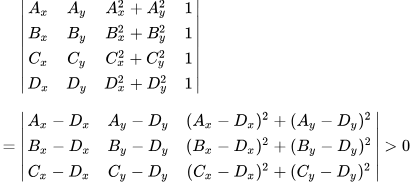

When A, B, C are sorted in a counterclockwise order, this determinant is positive only if D lies inside the circumcircle.

Proof:

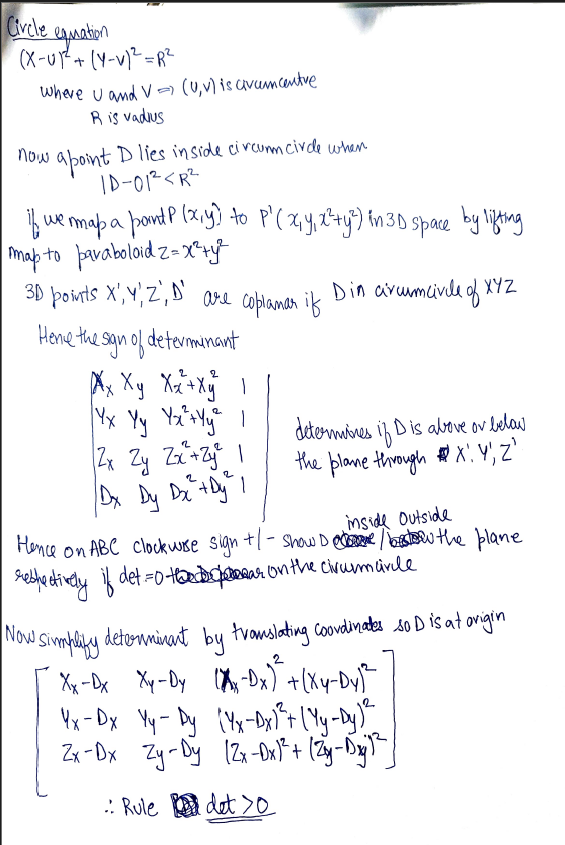

## Comparison with SciPy

Verification with 20 points for each dataset:

Random       - RIC:  33 triangles, Scipy:  33 triangles, Match: True
Gaussian     - RIC:  30 triangles, Scipy:  30 triangles, Match: True
Clustered    - RIC:  31 triangles, Scipy:  30 triangles, Match: False
  → In RIC only: {(3, 6, 7)}
  → In Scipy only: set()
Poisson      - RIC:  34 triangles, Scipy:  34 triangles, Match: True


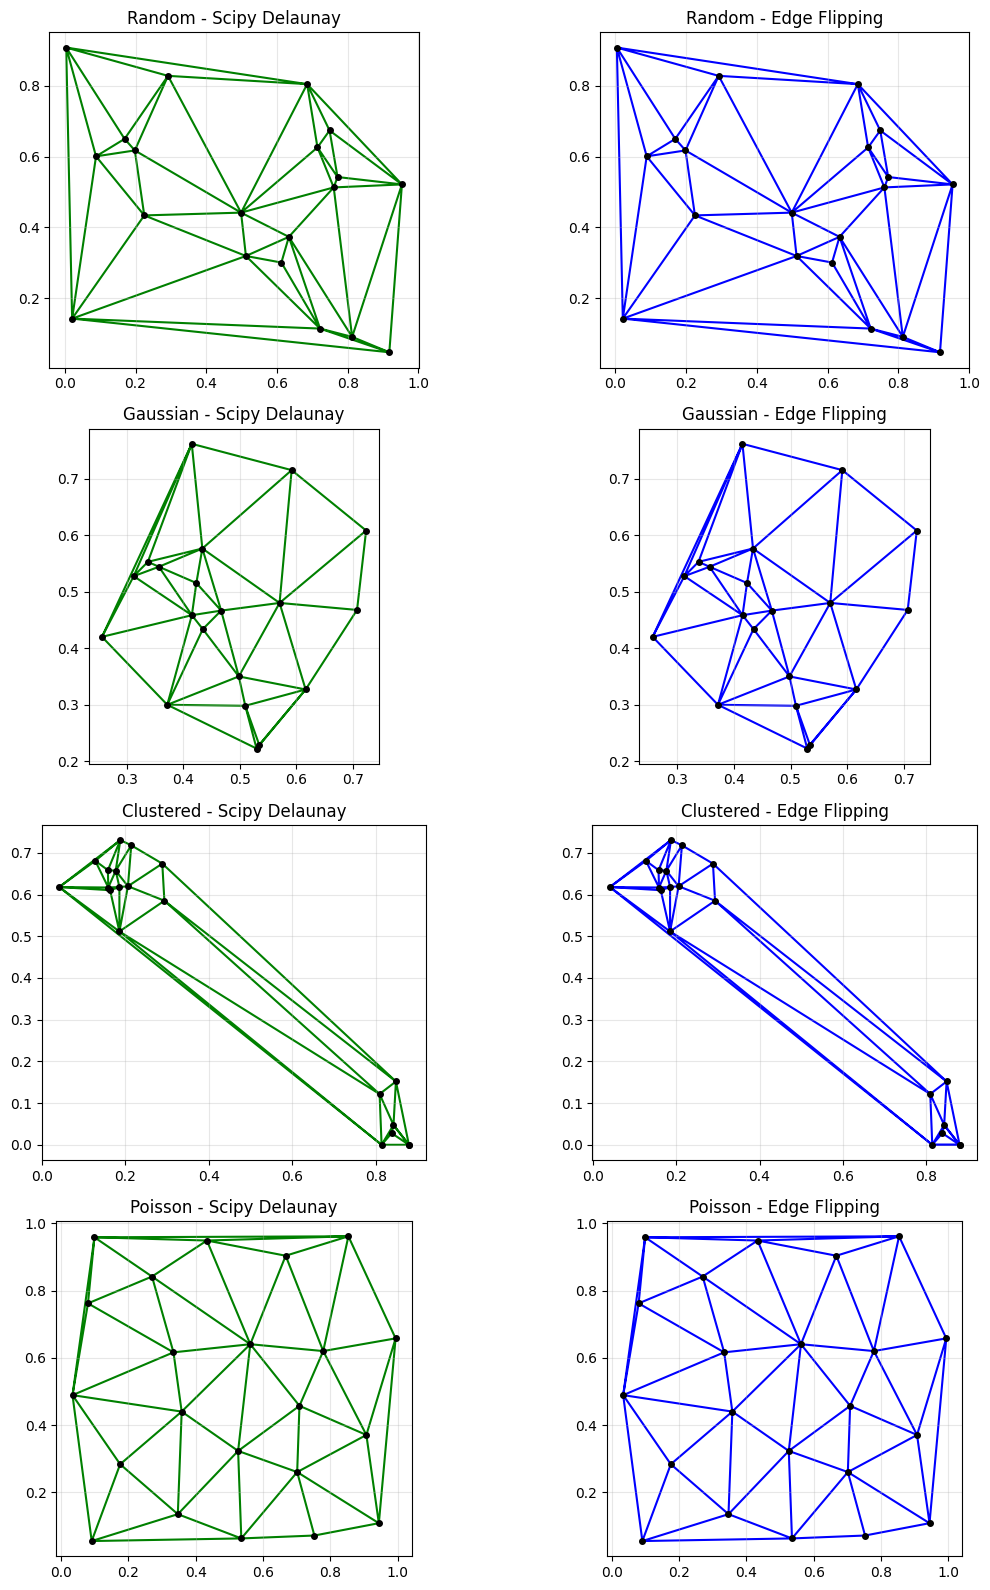

In [5]:
# Verification Step
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

# 1. Generate Data
n_verify = 20
points_verify = generate_random_points(n_points=n_verify, seed=10)
np.random.shuffle(points_verify)

points_verify_gauss = generate_gaussian_points(n_points=n_verify, seed=42)
np.random.shuffle(points_verify_gauss)

points_verify_clustered = generate_clustered_points(n_points=n_verify, seed=52)
np.random.shuffle(points_verify_clustered)

r = np.sqrt(0.625 / n_verify) 
points_verify_poisson = generate_poisson_disc_points(radius=r, seed=62)
np.random.shuffle(points_verify_poisson)

# 2. Run Flip Algorithm
custom_triangles, _ = triangulate_flipping(points_verify)
custom_triangles_gauss, _ = triangulate_flipping(points_verify_gauss)
custom_triangles_clustered, _ = triangulate_flipping(points_verify_clustered)
custom_triangles_poisson, _ = triangulate_flipping(points_verify_poisson)
# 3. Run Scipy Delaunay
delaunay = Delaunay(points_verify)
delaunay_gauss = Delaunay(points_verify_gauss)
delaunay_clustered = Delaunay(points_verify_clustered)
delaunay_poisson = Delaunay(points_verify_poisson)

scipy_simplices = delaunay.simplices
scipy_simplices_gauss = delaunay_gauss.simplices
scipy_simplices_clustered = delaunay_clustered.simplices
scipy_simplices_poisson = delaunay_poisson.simplices

# 4. Compare Results for all datasets
datasets = [
    ("Random", custom_triangles, scipy_simplices, points_verify),
    ("Gaussian", custom_triangles_gauss, scipy_simplices_gauss, points_verify_gauss),
    ("Clustered", custom_triangles_clustered, scipy_simplices_clustered, points_verify_clustered),
    ("Poisson", custom_triangles_poisson, scipy_simplices_poisson, points_verify_poisson)
]

print(f"Verification with {n_verify} points for each dataset:\n")
for name, custom, scipy, _ in datasets:
    custom_set = set(tuple(sorted(t)) for t in custom)
    scipy_set = set(tuple(sorted(t)) for t in scipy)
    is_correct = (custom_set == scipy_set)
    
    print(f"{name:12} - RIC: {len(custom_set):3d} triangles, Scipy: {len(scipy_set):3d} triangles, Match: {is_correct}")
    
    if not is_correct:
        print(f"  → In RIC only: {custom_set - scipy_set}")
        print(f"  → In Scipy only: {scipy_set - custom_set}")

# 5. Visualize All Datasets in a Grid
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for idx, (name, custom, scipy, points) in enumerate(datasets):
    # Scipy Plot (left column)
    axes[idx, 0].set_title(f"{name} - Scipy Delaunay")
    if len(scipy) > 0:
        axes[idx, 0].triplot(points[:, 0], points[:, 1], scipy, color='green')
    axes[idx, 0].plot(points[:, 0], points[:, 1], 'ko', markersize=4)
    axes[idx, 0].set_aspect('equal')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Edge Flipping Plot (right column)
    axes[idx, 1].set_title(f"{name} - Edge Flipping")
    if custom:
        axes[idx, 1].triplot(points[:, 0], points[:, 1], [list(t) for t in custom], color='blue')
    axes[idx, 1].plot(points[:, 0], points[:, 1], 'ko', markersize=4)
    axes[idx, 1].set_aspect('equal')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

```

## Performance Analysis
We will now analyze the performance of the Edge Flipping algorithm by counting the number of flips performed for different dataset sizes and distributions.
**Note:** Due to the performance limitations of a pure Python implementation, we will test up to $n=5000$ points.


In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

ns = [i for i in range(100, 10000, 500)]

results = {
    "Random": [],
    "Gaussian": [],
    "Clustered": [],
    "Poisson": []
}

for n in ns:
    print(f"Running for n={n}...")
    
    # Random
    pts = generate_random_points(n_points=n, seed=10)
    np.random.shuffle(pts)
    start_time = time.time()
    triangulate_flipping(pts)
    end_time = time.time()
    results["Random"].append(end_time - start_time)
    
    # Gaussian
    pts = generate_gaussian_points(n_points=n, seed=42)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_flipping(pts)
    end_time = time.time()
    results["Gaussian"].append(end_time - start_time)
    
    # Clustered
    pts = generate_clustered_points(n_points=n, seed=52)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_flipping(pts)
    end_time = time.time()
    results["Clustered"].append(end_time - start_time)
    
    # Poisson
    r = np.sqrt(0.625 / n) 
    pts = generate_poisson_disc_points(radius=r, seed=62)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_flipping(pts)
    end_time = time.time()
    results["Poisson"].append((len(pts), end_time - start_time))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(ns, results["Random"], label="Random (Uniform)", marker='o')
plt.plot(ns, results["Gaussian"], label="Gaussian", marker='s')
plt.plot(ns, results["Clustered"], label="Clustered", marker='^')

# Poisson scatter/line
p_ns = [x[0] for x in results["Poisson"]]
p_times = [x[1] for x in results["Poisson"]]

# Sort by n (just in case)
p_sorted = sorted(zip(p_ns, p_times))
p_ns = [x[0] for x in p_sorted]
p_times = [x[1] for x in p_sorted]

plt.plot(p_ns, p_times, label="Poisson Disc", marker='x')

plt.xlabel("Number of Points (n)")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken vs Number of Points (Shuffled Input)")
plt.legend()
plt.grid(True)
plt.show()

Running for n=100...
Running for n=600...
Running for n=1100...
Running for n=1600...
Running for n=2100...
Running for n=2600...
Running for n=3100...
Running for n=3600...
Running for n=4100...
Running for n=4600...
Running for n=5100...
Running for n=5600...
Running for n=6100...
Running for n=6600...
Running for n=7100...


## Visualisation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

def triangulate_generator(points):
    """
    A generator version of the flip algorithm.
    Yields (current_triangles, active_edge, status_message) at each step.
    """
    pts = np.asarray(points, dtype=float)
    n = len(pts)
    def orient(p, q, r):
        return (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])

    def in_circle_raw(a, b, c, d):
        ax, ay = a[0] - d[0], a[1] - d[1]
        bx, by = b[0] - d[0], b[1] - d[1]
        cx, cy = c[0] - d[0], c[1] - d[1]
        return (ax*ax + ay*ay) * (bx*cy - cx*by) - \
               (bx*bx + by*by) * (ax*cy - cx*ay) + \
               (cx*cx + cy*cy) * (ax*by - bx*ay)

    def in_circle_idx(i, j, k, l):
        a, b, c, d = pts[i], pts[j], pts[k], pts[l]
        det = in_circle_raw(a, b, c, d)
        if orient(a, b, c) < 0:
            det = -det
        return det > 0

    def convex_hull_indices():
        if n < 3: return list(range(n))
        order = sorted(range(n), key=lambda i: (pts[i][0], pts[i][1]))
        def cross(i, j, k): return orient(pts[i], pts[j], pts[k])
        
        lower = []
        for i in order:
            while len(lower) >= 2 and cross(lower[-2], lower[-1], i) <= 0: lower.pop()
            lower.append(i)
        upper = []
        for i in reversed(order):
            while len(upper) >= 2 and cross(upper[-2], upper[-1], i) <= 0: upper.pop()
            upper.append(i)
        return lower[:-1] + upper[:-1]

    hull = convex_hull_indices()
    
    half_edge = {}

    def add_triangle(u, v, w):
        if orient(pts[u], pts[v], pts[w]) < 0: v, w = w, v
        half_edge[(u, v)] = w
        half_edge[(v, w)] = u
        half_edge[(w, u)] = v

    def remove_triangle(u, v, w):
        del half_edge[(u, v)]
        del half_edge[(v, w)]
        del half_edge[(w, u)]

    def get_current_triangles():
        """Helper to extract unique triangles for plotting"""
        tris = []
        seen = set()
        for (u, v), w in half_edge.items():
            t = tuple(sorted((u, v, w)))
            if t not in seen:
                tris.append(t)
                seen.add(t)
        return tris
    
    # 1a. Fan the Hull
    h0 = hull[0]
    last_tri = None
    for i in range(1, len(hull) - 1):
        t = (h0, hull[i], hull[i+1])
        add_triangle(*t)
        last_tri = t
    
    yield get_current_triangles(), None, "Phase 1: Convex Hull Fan"

    # 1b. Insert Interior Points
    hull_set = set(hull)
    interior_indices = [i for i in range(n) if i not in hull_set]

    for p_idx in interior_indices:
        p = pts[p_idx]
        curr = last_tri
        steps = 0
        while True:
            u, v, w = curr
            if orient(pts[u], pts[v], p) < 0:
                opp = half_edge.get((v, u))
                if opp is None: break
                curr = (v, u, opp)
            elif orient(pts[v], pts[w], p) < 0:
                opp = half_edge.get((w, v))
                if opp is None: break
                curr = (w, v, opp)
            elif orient(pts[w], pts[u], p) < 0:
                opp = half_edge.get((u, w))
                if opp is None: break
                curr = (u, w, opp)
            else:
                break
            steps += 1
            if steps > 200: break

        u, v, w = curr
        remove_triangle(u, v, w)
        add_triangle(u, v, p_idx)
        add_triangle(v, w, p_idx)
        add_triangle(w, u, p_idx)
        last_tri = (u, v, p_idx)
        yield get_current_triangles(), None, f"Phase 1: Inserted Point {p_idx}"

    # --- Phase 2: Lawson Flips ---
    stack = list(half_edge.keys())
    
    while stack:
        a, b = stack.pop()
        if (a, b) not in half_edge: continue
        
        p = half_edge.get((a, b))
        opp = half_edge.get((b, a))
        if p is None or opp is None: continue
        if in_circle_idx(a, b, p, opp):
            # FLIP HAPPENING
            remove_triangle(a, b, p)
            remove_triangle(b, a, opp)
            add_triangle(a, opp, p)
            add_triangle(opp, b, p)
            stack.extend([(a, opp), (opp, a), (opp, b), (b, opp), (b, p), (p, b), (p, a), (a, p)])
            yield get_current_triangles(), (pts[a], pts[b]), "Phase 2: FLIP Performed!"

    yield get_current_triangles(), None, "Finished: Delaunay Triangulation"

def run_visualization():
    # 1. Generate Random Points
    np.random.seed(20)
    N_POINTS = 15
    points = np.random.rand(N_POINTS, 2)

    # 2. Setup Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Static Scatter of points
    ax.plot(points[:, 0], points[:, 1], 'o', color='black', zorder=3)
    # Annotate point indices
    for i, (x, y) in enumerate(points):
        ax.text(x + 0.01, y + 0.01, str(i), fontsize=9, color='gray')

    # Graphics containers
    lines_collection = LineCollection([], colors='blue', linewidths=1)
    ax.add_collection(lines_collection)
    
    highlight_line, = ax.plot([], [], color='red', linewidth=3, zorder=4)
    title_text = ax.set_title("Initializing...")

    # 3. Create the Generator
    algo_gen = triangulate_generator(points)

    def update(frame_data):
        current_tris, active_edge, message = frame_data
        
        # Update Triangles
        segments = []
        for (i, j, k) in current_tris:
            segments.append([points[i], points[j]])
            segments.append([points[j], points[k]])
            segments.append([points[k], points[i]])
        
        lines_collection.set_segments(segments)
        if active_edge is not None:
            p1, p2 = active_edge
            highlight_line.set_data([p1[0], p2[0]], [p1[1], p2[1]])
        else:
            highlight_line.set_data([], [])

        title_text.set_text(message)
        return lines_collection, highlight_line, title_text

    # 4. Run Animation
    anim = FuncAnimation(
        fig, 
        update, 
        frames=algo_gen, 
        interval=500, # Milliseconds per step
        repeat=False,
        save_count=200,
        cache_frame_data=False
    )
    
    return anim

if __name__ == "__main__":
    anim = run_visualization()
    try:
        from IPython import get_ipython
        if get_ipython() and 'ZMQInteractiveShell' in str(get_ipython().__class__):
            from IPython.display import HTML, display
            print("Rendering animation for Jupyter (this may take a few seconds)...")
            display(HTML(anim.to_jshtml()))
            plt.close()
        else:
            plt.show()
    except (ImportError, NameError):
        plt.show()

## Algorithm Explanation and Intuition
Main intuition: "A triangulation is Delaunay if and only if all edges are locally Delaunay." - source https://www.cise.ufl.edu/~ungor/delaunay/delaunay/node5.html

Hence the **Edge-Flipping Algorithm** starts with any valid triangulation of the given set of points. Each triangle’s edges are examined to verify if they are locally delaunay.

The **empty-circumcircle property** — a necessary and sufficient condition for Delaunay triangulations. If two adjacent triangles share an edge that violates this property (meaning the opposite vertex lies inside the circumcircle of the other triangle), that shared edge is **flipped** to connect the opposite pair of vertices instead. This flipping locally restores the Delaunay condition. The process repeats until no edge violates the property, producing the global Delaunay triangulation.

Intuitively, every edge flip replaces two skinny triangles with two that have larger minimum angles, thus eliminating long thin shapes and making the triangulation more stable and optimal geometrically.


## Proof Of Correctness
Each edge flip enforces the **empty-circumcircle property** for the local configuration of two triangles which was proved in the beginning of the document

In [ ]:
# Verification Step
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

# 1. Generate Data
n_verify = 20
points_verify = generate_random_points(n_points=n_verify, seed=123)

# 2. Run Flip Algorithm
custom_triangles, _ = triangulate_flipping(points_verify)

# 3. Run Scipy Delaunay
delaunay = Delaunay(points_verify)
scipy_simplices = delaunay.simplices

# 4. Compare Results
# Convert both to a set of sorted tuples for set comparison
custom_set = set(tuple(sorted(t)) for t in custom_triangles)
scipy_set = set(tuple(sorted(t)) for t in scipy_simplices)

is_correct = (custom_set == scipy_set)

print(f"Verification with {n_verify} random points:")
print(f"Custom Algorithm Triangles: {len(custom_set)}")
print(f"Scipy Delaunay Triangles:   {len(scipy_set)}")
print(f"Sets Match: {is_correct}")

if not is_correct:
    print("Mismatch details:")
    print("In Custom only:", custom_set - scipy_set)
    print("In Scipy only:", scipy_set - custom_set)

# 5. Visualize Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Custom Plot
axes[0].set_title("Custom Edge Flipping")
if custom_triangles:
    axes[0].triplot(points_verify[:, 0], points_verify[:, 1], [list(t) for t in custom_triangles], color='blue')
axes[0].plot(points_verify[:, 0], points_verify[:, 1], 'ko')
axes[0].set_aspect('equal')

# Scipy Plot
axes[1].set_title("Scipy Delaunay")
if len(scipy_simplices) > 0:
    axes[1].triplot(points_verify[:, 0], points_verify[:, 1], scipy_simplices, color='green')
axes[1].plot(points_verify[:, 0], points_verify[:, 1], 'ko')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

## Space Complexity Analysis
The algorithm maintains the list of triangles and adjacency relationships between them. Each triangle references three vertices, and each vertex participates in a bounded number of triangles. Therefore, the space required is **O(n)** for n input points, plus constant overhead for temporary edge and adjacency tracking.


## Time Complexity Analysis
Each flip operation takes **O(1)** time, and in the worst case, there may be **O(n²)** such flips. Hence the worst-case runtime is **O(n²)**. For random or well-distributed points, the number of flips tends to grow linearly, yielding an expected runtime of **O(n)** to **O(n log n)** depending on the initial triangulation. The edge-flipping algorithm is thus efficient for small or moderately sized point sets and serves as an effective post-processing step to enforce Delaunay optimality.
